# CE-40719: Deep Learning
## HW6 - Deep Reinforcement Learning

(40 points)

#### Name: َAmirHossein Mohammadi
#### Student No.: 99201081


In this assignment, we are going to design an agent to play Atari game. 
we will use a wrapper to change MDP problem to POMDP, as a result, we are able to investigate the efficiency of using memory to solve problems in a partial observability setting.
For this reseaon, we use a Deep Q-Network model as memory less architecture and a [DRQN](https://arxiv.org/abs/1507.06527) as a memoryful agent to play game Pong(`PongNoFrameskip-v4` environment of [gym](https://gym.openai.com/) library).
In this environment, the observation is an RGB image of the screen, which is an array of shape (210, 160, 3). And action space is 6.
We will train the model for 200,000 steps and should take approximately 2 hour.

At the end, you should be able to conclude effectiveness of recurrent memory to cancel out noisy observation.


![Pong](https://cdn-images-1.medium.com/max/800/1*UHYJE7lF8IDZS_U5SsAFUQ.gif)

 ### 1. Setup

if you use google colab to train your network, mount to google drive would be necessary 

In [1]:
from google.colab import drive
drive._mount('/content/drive')

First, we need to install `stable-baselines`. This library  is a set of improved implementations of Reinforcement Learning (RL) algorithms based on OpenAI Baselines. We will use some of **wrappers** of this library. Wrappers will allow us to add functionality to environments, such as modifying observations and rewards to be fed to our agent. It is common in reinforcement learning to preprocess observations in order to make them more easy to learn from. 

- For linux based Operating Systems or google colab run cell below:

In [2]:
%%shell

sudo apt-get update && sudo apt-get install cmake libopenmpi-dev zlib1g-dev

pip install stable-baselines[mpi]==2.8.0

Get:1 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease [3,626 B]
Ign:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Ign:3 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Get:4 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release [696 B]
Get:5 http://security.ubuntu.com/ubuntu bionic-security InRelease [88.7 kB]
Get:6 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease [15.9 kB]
Hit:7 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Get:8 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release.gpg [836 B]
Hit:9 http://archive.ubuntu.com/ubuntu bionic InRelease
Get:11 http://archive.ubuntu.com/ubuntu bionic-updates InRelease [88.7 kB]
Get:12 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Packages [917 kB]
Hit:13 http://ppa.laun

- For Windows: 
    - First install [MPI for Windows](https://www.microsoft.com/en-us/download/details.aspx?id=57467) (you need to download and install `msmpisetup.exe`)
    - Then run this command in Prompt: `pip install stable-baselines[mpi]==2.8.0`

install ROMs which needed for creating atari env

In [3]:
import urllib.request
urllib.request.urlretrieve('http://www.atarimania.com/roms/Roms.rar','Roms.rar')
!pip install unrar
!unrar x Roms.rar
!mkdir rars
!mv HC\ ROMS.zip   rars
!mv ROMS.zip  rars
!python -m atari_py.import_roms rars


UNRAR 5.50 freeware      Copyright (c) 1993-2017 Alexander Roshal


Extracting from Roms.rar

Extracting  HC ROMS.zip                                                   36%  OK 
Extracting  ROMS.zip                                                      74% 99%  OK 
All OK
copying adventure.bin from HC ROMS/BY ALPHABET (PAL)/A-G/Adventure (PAL).bin to /usr/local/lib/python3.7/dist-packages/atari_py/atari_roms/adventure.bin
copying air_raid.bin from HC ROMS/BY ALPHABET (PAL)/A-G/Air Raid (PAL).bin to /usr/local/lib/python3.7/dist-packages/atari_py/atari_roms/air_raid.bin
copying alien.bin from HC ROMS/BY ALPHABET (PAL)/A-G/REMAINING NTSC ORIGINALS/Alien.bin to /usr/local/lib/python3.7/dist-packages/atari_py/atari_roms/alien.bin
copying crazy_climber.bin from HC ROMS/BY ALPHABET (PAL)/A-G/REMAINING NTSC ORIGINALS/Crazy Climber.bin to /usr/local/lib/python3.7/dist-packages/atari_py/atari_roms/crazy_climber.bin
copying elevator_action.bin from HC ROMS/BY ALPHABET (PAL)/

### 2. Import Libraries:

In [4]:
import random, os.path, math, glob, csv, os
import numpy as np

from timeit import default_timer as timer
from datetime import timedelta

import matplotlib
%matplotlib inline
from IPython.display import clear_output
from plot import plot_all_data 

import torch
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F

# ######################## #
# USE ONLY IN GOOGLE COLAB #
%tensorflow_version 1.x 
# ######################## #

import gym
from gym.spaces.box import Box
from stable_baselines import bench
from stable_baselines.common.atari_wrappers import make_atari, wrap_deepmind

TensorFlow 1.x selected.
The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.



### 2. Hyperparameters

In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Epsilon variables for epsilon-greedy:
epsilon_start    = 1.0
epsilon_final    = 0.01
epsilon_decay    = 30000
epsilon_by_frame = lambda frame_idx: epsilon_final + (epsilon_start - epsilon_final) * math.exp(-1. * frame_idx / epsilon_decay) 

# Misc agent variables
GAMMA = 0.99 
LR    = 1e-4 

# Memory
TARGET_NET_UPDATE_FREQ = 1000 
EXP_REPLAY_SIZE        = 100000 
BATCH_SIZE             = 32 

# Learning control variables
LEARN_START = 10000
MAX_FRAMES  = 200000 # Probably takes about an hour training. You can increase it if you have time!
UPDATE_FREQ = 1 

# Data logging parameters
ACTION_SELECTION_COUNT_FREQUENCY = 1000 

#DRQN Parameters
SEQUENCE_LENGTH = 8

### 3. Wrapper

In [6]:
class WrapPOMDP(gym.ObservationWrapper):
    def __init__(self, env=None):
        super(WrapPOMDP, self).__init__(env)
        obs_shape = self.observation_space.shape
        self.observation_space = Box(
            self.observation_space.low[0, 0, 0],
            self.observation_space.high[0, 0, 0],
            [obs_shape[2], obs_shape[1], obs_shape[0]],
            dtype=self.observation_space.dtype)

    def observation(self, observation):
        # this method change MDP into POMDP
        pomdp = np.random.uniform()
        if pomdp >= 0.5:
          return observation.transpose(2, 0, 1)
        else:
          return observation.transpose(2, 0, 1) * 0.0

### 4. Abstract Agent Class (3 Points)

In [7]:
class BaseAgent():
    def __init__(self, model, target_model, log_dir, env):
        self.device = device
        self.gamma = GAMMA
        self.lr = LR
        self.target_net_update_freq = TARGET_NET_UPDATE_FREQ
        self.experience_replay_size = EXP_REPLAY_SIZE
        self.batch_size = BATCH_SIZE
        self.learn_start = LEARN_START
        self.update_freq = UPDATE_FREQ
        self.update_count = 0
        self.nstep_buffer = []
        self.rewards = []
        self.model = model
        self.target_model = target_model
        #################################################################################
        #                          COMPLETE THE FOLLOWING SECTION                       #
        #################################################################################
        # compelete this method
        # * save log_dir
        # * save env
        # * make a list of action selections
        # * using load_state_dict, share learnable parameters (i.e. weights and biases) of
        #   self.model with self.target_model 
        # * move both model to correct device
        # * use Adam optimizer
        # * set both model to train mode
        #################################################################################
        self.log_dir = log_dir 
        self.env = env
        self.action_selections = [0 for _ in range (self.env.action_space.n)]
        self.target_model.load_state_dict(self.model.state_dict())
        self.target_model=self.target_model.to(self.device)
        self.model=self.model.to(self.device)
        self.optimizer = optim.Adam(params=self.model.parameters(),lr=self.lr)
        self.target_model.train()
        self.model.train()
        #################################################################################
        #                                   THE END                                     #
        #################################################################################

    def update_target_model(self):
        # update target model:
        self.update_count += 1
        self.update_count = self.update_count % self.target_net_update_freq
        if self.update_count == 0:
            self.target_model.load_state_dict(self.model.state_dict())

    def save_sigma_param_magnitudes(self, tstep):
        with torch.no_grad():
            sum_, count = 0.0, 0.0
            for name, param in self.model.named_parameters():
                if param.requires_grad and 'sigma' in name:
                    sum_ += torch.sum(param.abs()).item()
                    count += np.prod(param.shape)
            if count > 0:
                with open(os.path.join(self.log_dir, 'sig_param_mag.csv'), 'a') as f:
                    writer = csv.writer(f)
                    writer.writerow((tstep, sum_ / count))

    def save_td(self, td, tstep):
        with open(os.path.join(self.log_dir, 'td.csv'), 'a') as f:
            writer = csv.writer(f)
            writer.writerow((tstep, td))

    def save_reward(self, reward):
        self.rewards.append(reward)

    def save_action(self, action, tstep):
        self.action_selections[int(action)] += 1.0 / self.action_log_frequency
        if (tstep + 1) % self.action_log_frequency == 0:
            with open(os.path.join(self.log_dir, 'action_log.csv'), 'a') as f:
                writer = csv.writer(f)
                writer.writerow(list([tstep] + self.action_selections))
            self.action_selections = [0 for _ in range(len(self.action_selections))]

    def get_max_next_state_action(self, next_states):
        return self.target_model(next_states).max(dim=1)[1].view(-1, 1)

# 1. Simple DQN

We will implement a DQN model with experience replay. We implement a class for experience replay  `ExperienceReplayMemory`, for extarct features of observed picture of game we implement a class `DQN` that uses a CNN and inheritance from `nn.Module`. We implemented a wrapper class `WrapPyTorch` that you will use it in training loop.

## 1.1. Experience Replay (3 Points)

In [8]:
#################################################################################
#                          COMPLETE THE FOLLOWING SECTION                       #
#################################################################################
# complete push and sample methods.
#################################################################################
class ExperienceReplayMemory:
    def __init__(self, capacity):
        self.capacity = capacity
        self.memory = []

    def push(self, transition):
        self.memory.append(transition)
        if len(self.memory)>self.capacity:
          del self.memory[0]

    def sample(self, batch_size):
        return random.sample(self.memory,batch_size)

    def __len__(self):
        return len(self.memory)
#################################################################################
#                                   THE END                                     #
#################################################################################  

## 1.2. Network Declaration (4 Points)

In [9]:
class DQN(nn.Module):
    def __init__(self, input_shape, num_actions):
        super(DQN, self).__init__()
        
        self.input_shape = input_shape
        self.num_actions = num_actions
        #################################################################################
        #                          COMPLETE THE FOLLOWING SECTION                       #
        #################################################################################
        # Initialize CNN Model :
        # conv1: out_channels:32, kernel_size=8, stride=4
        # conv2: out_channels:64, kernel_size=4, stride=2
        # conv3: out_channels:64, kernel_size=3, stride=1
        # fc1(512)
        # fc2(512)
        #################################################################################
        self.inputshape=self.input_shape[0]
        self.conv1=nn.Conv2d(self.inputshape,32,kernel_size=8,stride=4)
        self.conv2=nn.Conv2d(32,64,kernel_size=4,stride=2)
        self.conv3=nn.Conv2d(64,64,kernel_size=3,stride=1)
        self.fc_input_shape=self.conv3(self.conv2(self.conv1(torch.zeros(1,*self.input_shape)))).view(1,-1).size(1)
        self.fc1=nn.Linear(self.fc_input_shape,512)
        self.fc2=nn.Linear(512,self.num_actions)
        #################################################################################
        #                                   THE END                                     #
        #################################################################################

    def forward(self, x):
        #################################################################################
        #                          COMPLETE THE FOLLOWING SECTION                       #
        #################################################################################
        # complete forward pass using initialized CNN Model. use Relu activation function 
        # for conv1, conv2, conv3, and fc1.  
        #################################################################################
        x=F.relu(self.conv1(x))
        x=F.relu(self.conv2(x)) 
        x=F.relu(self.conv3(x))
        x=x.view(x.size(0),-1)
        x=F.relu(self.fc1(x))
        x=self.fc2(x)
        return x
        #################################################################################
        #                                   THE END                                     #
        #################################################################################   



 ## 1.3. Agent (6 Points)

In [10]:
class Model(BaseAgent):
    def __init__(self,  log_dir, env=None):
        self.device = device

        self.gamma = GAMMA 
        self.lr = LR
        self.target_net_update_freq = TARGET_NET_UPDATE_FREQ
        self.experience_replay_size = EXP_REPLAY_SIZE
        self.batch_size = BATCH_SIZE
        self.learn_start = LEARN_START
        self.update_freq = UPDATE_FREQ
        self.log_dir = log_dir
        self.rewards = []
        self.action_log_frequency = ACTION_SELECTION_COUNT_FREQUENCY
        #################################################################################
        #                          COMPLETE THE FOLLOWING SECTION                       #
        #################################################################################
        # do followings line by line:
        # * make a list of action selections
        # * use shape of observation space to save number of features
        # * save naumber of actions
        # * use DQN class to declare model and target model (the game is 2-player game, so
        #   we declare 2 model)
        # * using load_state_dict, share learnable parameters (i.e. weights and biases) of
        #   self.model with self.target_model 
        # * use Adam optimizer
        #################################################################################
        self.num_feats = env.observation_space.shape
        self.num_actions = env.action_space.n
        self.action_selections = [0 for _ in range (self.num_actions)]
        self.model = DQN(self.num_feats,self.num_actions)
        self.target_model = DQN(self.num_feats,self.num_actions)
        self.target_model.load_state_dict(self.model.state_dict())
        self.optimizer=optim.Adam(self.model.parameters(),lr=self.lr)
        super(Model, self).__init__(self.model,self.target_model,self.log_dir,env)
        #################################################################################
        #                                   THE END                                     #
        #################################################################################
        
        self.memory = ExperienceReplayMemory(self.experience_replay_size)
        

    def prep_minibatch(self):
      
        #################################################################################
        #                          COMPLETE THE FOLLOWING SECTION                       #
        #################################################################################
        # random transition batch is taken from experience replay memory
        # do followings line by line:
        # * sample from self.memory with batch size, and save result in transitions
        # * use transitions to save batch_state, batch_action, batch_reward, 
        #   batch_next_state as tensors
        # * save non_final_mask,  non_final_next_states as tensors, note that sometimes 
        #   all next states are false
        #################################################################################
        transitions = self.memory.sample(self.batch_size)
        batch_state, batch_action, batch_reward, batch_next_state = zip(*transitions)
        batch_state = torch.tensor(batch_state,device=self.device,dtype=torch.float).view((-1,)+self.num_feats)
        batch_action = torch.tensor(batch_action,device=self.device,dtype=torch.long).squeeze().view(-1,1)
        batch_reward = torch.tensor(batch_reward,device=self.device,dtype=torch.long).squeeze().view(-1,1)
        non_final_mask = torch.tensor(tuple(map(lambda s: s is not None, batch_next_state)), device=self.device,dtype=torch.uint8)  

        try: 
            non_final_next_states = torch.tensor([s for s in batch_next_state if s is not None],device=self.device,dtype=torch.float).view((-1,)+self.num_feats)
            empty_next_state_values = False
        except:
            non_final_next_states = None
            empty_next_state_values = True
        #################################################################################
        #                                   THE END                                     #
        #################################################################################
        return batch_state, batch_action, batch_reward, non_final_next_states, non_final_mask, empty_next_state_values

    def compute_loss(self, batch_vars):
        batch_state, batch_action, batch_reward, non_final_next_states, non_final_mask, empty_next_state_values = batch_vars

        #################################################################################
        #                          COMPLETE THE FOLLOWING SECTION                       #
        #################################################################################
        # implement calculation of loss (you should use "with torch.no_grad():" for target_model)
        #################################################################################
        current_q_values = self.model(batch_state).gather(1, batch_action)
        with torch.no_grad():
            max_next_q_values = torch.zeros(self.batch_size, device=self.device, dtype=torch.float).unsqueeze(dim=1)
            if not empty_next_state_values:
                max_next_action = self.get_max_next_state_action(non_final_next_states)
                max_next_q_values[non_final_mask] = self.target_model(non_final_next_states).gather(1, max_next_action)
            expected_q_values = batch_reward + self.gamma*max_next_q_values
        loss = 0.5*(expected_q_values - current_q_values).pow(2)
        loss=loss.mean()
        #################################################################################
        #                                   THE END                                     #
        #################################################################################
        return loss

    def update(self, s, a, r, s_, frame=0):
        #################################################################################
        #                          COMPLETE THE FOLLOWING SECTION                       #
        #################################################################################
        # implement update method to optimize model 
        # * push state, action, reward and new state to memoty
        # * note that if frame is lower than self.learn_start or frame % self.update_freq != 0
        #   return None
        # * take a random transition batch and compute loss
        # * optimize the model
        #################################################################################
        self.memory.push(( s, a, r, s_))
        if frame< self.learn_start or frame %self.update_freq!=0:
          return None

        batch_vars=self.prep_minibatch()
        loss=self.compute_loss(batch_vars)
        self.optimizer.zero_grad()
        loss.backward()
        for param in self.model.parameters():
          param.grad.data.clamp_(-1,1)
        self.optimizer.step()
        #################################################################################
        #                                   THE END                                     #
        #################################################################################

        self.update_target_model()       
        self.save_td(loss.item(), frame)
        self.save_sigma_param_magnitudes(frame)

    def get_action(self, s, eps=0.1):

        #################################################################################
        #                          COMPLETE THE FOLLOWING SECTION                       #
        #################################################################################  
         # implement get_action method (epsilon greedy)
         # you should use "with torch.no_grad():"
         ################################################################################# 
        with torch.no_grad():
          if np.random.random()>=eps:
            x=torch.tensor([s],device=self.device,dtype=torch.float)
            temp=self.model(x).max(1)[1].view(1,1)
            return temp.item()
          else:
            return np.random.randint(0,self.num_actions)
        #################################################################################
        #                                   THE END                                     #
        #################################################################################

    def update_target_model(self):
      # update target model:
        self.update_count+=1
        self.update_count = self.update_count % self.target_net_update_freq
        if self.update_count == 0:
            self.target_model.load_state_dict(self.model.state_dict())



 ## 1.3. Training Loop (4 Points)

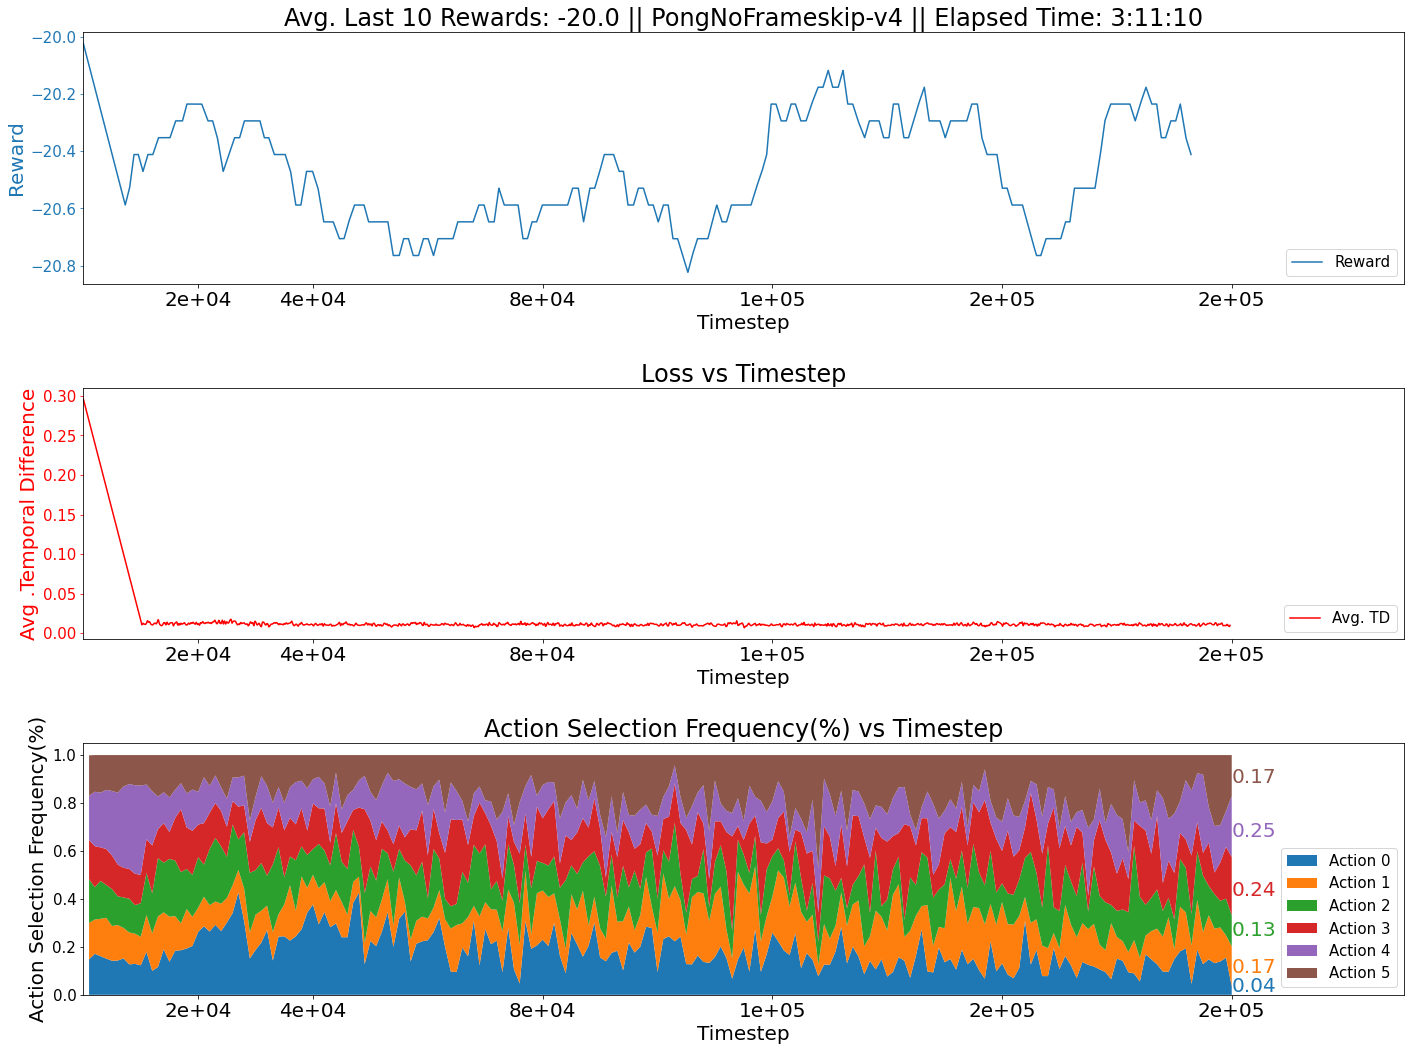

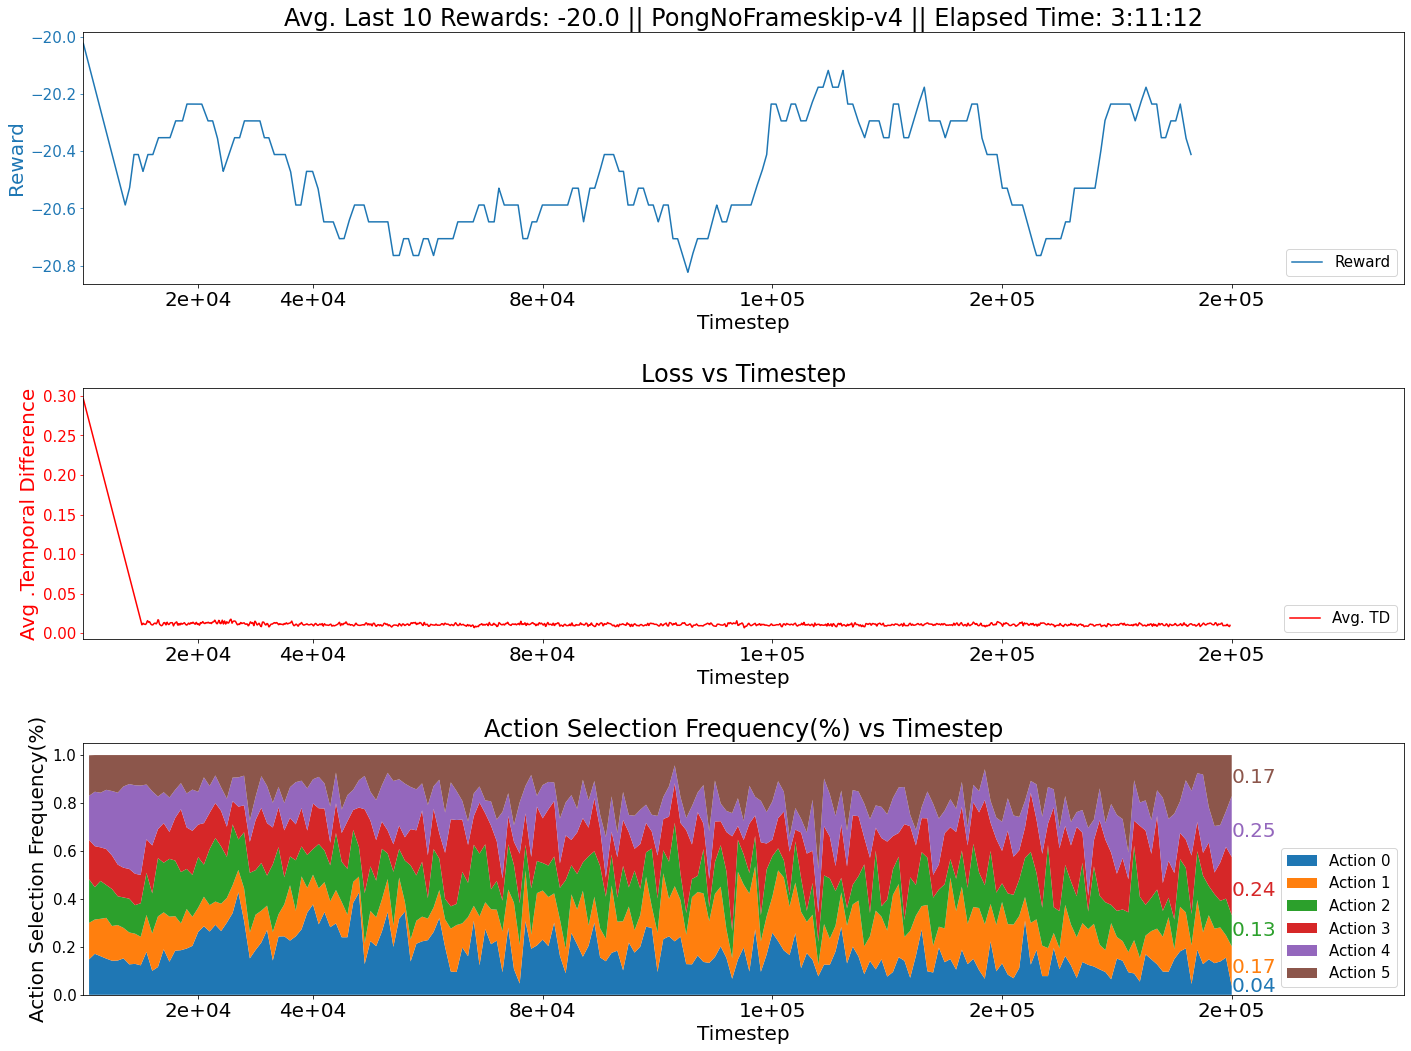

In [ ]:
start=timer()

log_dir = "/tmp/gym/dqn"
try:
    os.makedirs(log_dir)
except OSError:
    files = glob.glob(os.path.join(log_dir, '*.monitor.csv')) \
        + glob.glob(os.path.join(log_dir, '*td.csv')) \
        + glob.glob(os.path.join(log_dir, '*sig_param_mag.csv')) \
        + glob.glob(os.path.join(log_dir, '*action_log.csv'))
    for f in files:
        os.remove(f)

#################################################################################
#                          COMPLETE THE FOLLOWING SECTION                       #
#################################################################################
# do followings line by line:
# * use "make_atari" wrapper and save "PongNoFrameskip-v4" game to env
# * use "bench.Monitor" wrapper to know the episode reward, length, time and other data.
# * use "wrap_deepmind" wrapper to configure environment for DeepMind-style Atari.
# * use *WrapPyTorch*
# * save model
# * implement training loop
#################################################################################
env_id = "PongNoFrameskip-v4"
env =make_atari(env_id)
env=bench.Monitor(env,os.path.join(log_dir,env_id))
env=wrap_deepmind(env,episode_life=True,clip_rewards=True,frame_stack=False,scale=True)
env=WrapPOMDP(env)
model = Model(log_dir,env)
episode_reward = 0
observation = env.reset()
for frame_idx in range(1, MAX_FRAMES + 1):
    epsilon = epsilon_by_frame(frame_idx)
    action = model.get_action(observation,epsilon)
    model.save_action(action, frame_idx)
    prev_observation = observation
    observation, reward, done, _ = env.step(action)
    observation=None if done else observation
    model.update(prev_observation,action,reward,observation,frame_idx)
    episode_reward+=reward

    if done:
        observation=env.reset()
        model.save_reward(episode_reward)
        episode_reward=0
        
#################################################################################
#                                   THE END                                     #
################################################################################# 
    if frame_idx % 1000 == 0:
        try:
            clear_output(True)
            plot_all_data(log_dir, env_id, 'DQN', MAX_FRAMES, bin_size=(10, 100, 100, 1), smooth=1, time=timedelta(seconds=int(timer()-start)), ipynb=True)
        except IOError:
            pass
 
env.close()
plot_all_data(log_dir, env_id, 'DQN', MAX_FRAMES, bin_size=(10, 100, 100, 1), smooth=1, time=timedelta(seconds=int(timer()-start)), ipynb=True)

# 2. DRQN

## 2.1. Experience Replay (4 Points)

In [15]:
class RecurrentExperienceReplayMemory:
    def __init__(self, capacity, sequence_length=10):
        self.capacity = capacity
        self.memory = []
        self.seq_length = sequence_length

    def push(self, transition):
        #################################################################################
        #                          COMPLETE THE FOLLOWING SECTION                       #
        #################################################################################
        # complete push method.
        #################################################################################
        self.memory.append(transition)
        if len(self.memory) > self.capacity:
            del self.memory[0]
        #################################################################################
        #                                   THE END                                     #
        #################################################################################  

    def sample(self, batch_size):
        #################################################################################
        #                          COMPLETE THE FOLLOWING SECTION                       #
        #################################################################################
        # complete sample method.
        # notice that you should take these tips into consideration
        # * sample here will be trajectory not transition
        # * should use padding if trajectories aren't in same len
        #################################################################################
        samples = []
        f_satet = random.sample(range(0, len(self.memory)), batch_size)
        b_state = [x-self.seq_length for x in f_satet]
        for start, end in zip(b_state, f_satet):
            final_state = self.memory[max(start+1,0):end+1]
            for i in range(len(final_state)-2, -1, -1):
                if final_state[i][3] is None:
                    final_state = final_state[i+1:]
                    break
            while(len(final_state)<self.seq_length):
                final_state = [(np.zeros_like(self.memory[0][0]), 0, 0, np.zeros_like(self.memory[0][3]))] + final_state            
            samples+=final_state
        #################################################################################
        #                                   THE END                                     #
        #################################################################################  
        return samples

    def __len__(self):
        return len(self.memory)

## 2.2. Network Declaration (4 Points)

In [18]:
class RecurrentDQN(nn.Module):
    def __init__(self, input_shape, num_actions):
        super(RecurrentDQN,self).__init__()
        
        self.input_shape = input_shape
        self.num_actions = num_actions
        #################################################################################
        #                          COMPLETE THE FOLLOWING SECTION                       #
        #################################################################################
        # Initialize CNN Model :
        # conv1: out_channels:32, kernel_size=8, stride=4
        # conv2: out_channels:64, kernel_size=4, stride=2
        # conv3: out_channels:64, kernel_size=3, stride=1
        # fc2(256)
        # GRU:  input_size: 256  hidden_size=256
        # fc2(256)
        #################################################################################
        self.conv1=nn.Conv2d(in_channels=self.input_shape[0],out_channels=32,kernel_size=8,stride=4)
        self.conv2=nn.Conv2d(in_channels=32,out_channels= 64,kernel_size=4,stride=2)
        self.conv3=nn.Conv2d(in_channels=64,out_channels=64,kernel_size=3,stride=1)
        self.fc_input_shape=self.conv3(self.conv2(self.conv1(torch.zeros(1,*self.input_shape)))).view(1,-1).size(1)
        self.fc1=nn.Linear(self.fc_input_shape,256)
        self.gru=nn.GRU(input_size=256,hidden_size=256,batch_first=True)
        self.fc2=nn.Linear(256,self.num_actions)
        #################################################################################
        #                                   THE END                                     #
        #################################################################################

    def forward(self, x, bsize, time_step=None, hidden_state=None, cell_state=None):
        #################################################################################
        #                          COMPLETE THE FOLLOWING SECTION                       #
        #################################################################################
        # complete forward pass using initialized CNN and GRU Model. use Relu activation
        # function for conv1, conv2, conv3 and fc1 . 
        #################################################################################
        seq_size=x.size(1)
        x=F.relu(self.conv1(x.view((-1,)+self.input_shape)))
        x=F.relu(self.conv2(x)) 
        x=F.relu(self.conv3(x))
        x=x.view(x.size(0),-1)
        x=F.relu(self.fc1(x))
        x=x.view(bsize,seq_size,-1)
        hidden = self.init_hidden_states(bsize)
        out, hidden = self.gru(x, hidden)
        x=self.fc2(out)
        return x, hidden  
      
    def init_hidden_states(self,bsize):
        h = torch.zeros(1, bsize, 256, device=device, dtype=torch.float)
        return h
        #################################################################################
        #                                   THE END                                     #
        #################################################################################   



 ## 2.3. Agent (6 Points)

In [26]:
class RecurrentModel(Model):
    def __init__(self,log_dir,env=None):
        self.sequence_length = SEQUENCE_LENGTH
        #################################################################################
        #                          COMPLETE THE FOLLOWING SECTION                       #
        #################################################################################
        # do followings line by line:
        # * use shape of observation space to save number of features
        # * save naumber of actions
        # * use DRQN class to declare model and target model 
        # * call parent class constructor
        # * declare memory
        # * reset hidden state
        #################################################################################
        super(RecurrentModel, self).__init__(log_dir,env)
        self.num_feats = env.observation_space.shape
        self.num_actions = env.action_space.n
        self.model = RecurrentDQN(self.num_feats,self.num_actions).to(device)
        self.target_model = RecurrentDQN(self.num_feats,self.num_actions).to(device)
        self.memory = RecurrentExperienceReplayMemory(self.experience_replay_size, self.sequence_length)
        self.reset_hx()
        #################################################################################
        #                                   THE END                                     #
        #################################################################################
        

    def prep_minibatch(self):
      
        #################################################################################
        #                          COMPLETE THE FOLLOWING SECTION                       #
        #################################################################################
        # random transition batch is taken from experience replay memory
        # do followings line by line:
        # * sample from self.memory with batch size, and save result in transitions
        # * use transitions to save batch_state, batch_action, batch_reward, 
        #   batch_next_state as tensors
        # * reshape batch_state, batch_action, batch_reward, batch_next_state into 
        #   (batch_size, sequence_length, feat_size)
        # * get set of next states for end of each sequence
        # * save non_final_mask,  non_final_next_states as tensors, note that sometimes 
        #   all next states are false
        #################################################################################
        transitions = self.memory.sample(self.batch_size)
        batch_state, batch_action, batch_reward, batch_next_state = zip(*transitions)
        shape = (self.batch_size,self.sequence_length)+self.num_feats
        batch_state = torch.tensor(batch_state, device=self.device, dtype=torch.float).view(shape)
        batch_action = torch.tensor(batch_action, device=self.device, dtype=torch.long).view(self.batch_size, self.sequence_length, -1)
        batch_reward = torch.tensor(batch_reward, device=self.device, dtype=torch.float).view(self.batch_size, self.sequence_length)
        batch_next_state = tuple([batch_next_state[i] for i in range(len(batch_next_state)) if (i+1)%(self.sequence_length)==0])
        non_final_mask = torch.tensor(tuple(map(lambda s: s is not None, batch_next_state)), device=self.device, dtype=torch.uint8)
        try: 
            non_final_next_states = torch.tensor([s for s in batch_next_state if s is not None], device=self.device, dtype=torch.float).unsqueeze(dim=1)
            non_final_next_states = torch.cat([batch_state[non_final_mask, 1:, :], non_final_next_states], dim=1)
            empty_next_state_values = False
        except:
            non_final_next_states = None
            empty_next_state_values = True
        #################################################################################
        #                                   THE END                                     #
        #################################################################################
        return batch_state, batch_action, batch_reward, non_final_next_states, non_final_mask, empty_next_state_values

    def compute_loss(self, batch_vars):
        batch_state, batch_action, batch_reward, non_final_next_states, non_final_mask, empty_next_state_values = batch_vars

        #################################################################################
        #                          COMPLETE THE FOLLOWING SECTION                       #
        #################################################################################
        # implement calculation of loss (you should use "with torch.no_grad():" for target_model)
        #################################################################################
        bsize=batch_state.size(0)
        current_q_values, _ = self.model(batch_state,bsize)
        current_q_values = current_q_values.gather(2, batch_action).squeeze()
        with torch.no_grad():
            max_next_q_values = torch.zeros((self.batch_size, self.sequence_length), device=self.device, dtype=torch.float)
            if not empty_next_state_values:
                bsize=non_final_next_states.size(0)
                max_next, _ = self.target_model(non_final_next_states,bsize)
                max_next_q_values[non_final_mask] = max_next.max(dim=2)[0]
            expected_q_values = batch_reward + ((self.gamma**1)*max_next_q_values)

        diff = (expected_q_values - current_q_values)
        cond = (diff.abs()<1.0).float().detach()
        loss = 0.5 * diff.pow(2) * cond + (diff.abs() - 0.5) * (1.0-cond)
        split = self.sequence_length // 2
        mask = torch.zeros(self.sequence_length, device=self.device, dtype=torch.float)
        mask[split:] = 1.0
        mask = mask.view(1, -1)
        loss *= mask
        
        loss = loss.mean()
        #################################################################################
        #                                   THE END                                     #
        #################################################################################
        return loss

    def update(self, s, a, r, s_, frame=0):
        #################################################################################
        #                          COMPLETE THE FOLLOWING SECTION                       #
        #################################################################################
        # implement update method to optimize model 
        # * push state, action, reward and new state to memoty
        # * note that if frame is lower than self.learn_start or frame % self.update_freq != 0
        #   return None
        # * take a random transition batch and compute loss
        # * clamp grad between -1 and 1
        # * optimize the model 
        #################################################################################
        self.memory.push(( s, a, r, s_))
        if frame< self.learn_start or frame %self.update_freq!=0:
          return None

        batch_vars=self.prep_minibatch()
        loss=self.compute_loss(batch_vars)

        self.optimizer.zero_grad()
        loss.backward()

        for param in self.model.parameters():
          param.grad.data.clamp_(-1,1)
        self.optimizer.step()
        #################################################################################
        #                                   THE END                                     #
        #################################################################################

        self.update_target_model()       
        self.save_td(loss.item(), frame)
        self.save_sigma_param_magnitudes(frame)

    def get_action(self, s, eps=0.1):

        #################################################################################
        #                          COMPLETE THE FOLLOWING SECTION                       #
        #################################################################################  
         # implement get_action method (epsilon greedy)
         # you should use "with torch.no_grad():"
         ################################################################################# 
        with torch.no_grad():
            self.seq.pop(0)
            self.seq.append(s)
            if np.random.random() >= eps:
                X = torch.tensor([self.seq], device=self.device, dtype=torch.float) 
                bsize=X.size(0)
                a, _ = self.model(X,bsize)
                a = a[:, -1, :] 
                a = a.max(1)[1]
                return a.item()
            else:
                return np.random.randint(0, self.num_actions)

        #################################################################################
        #                                   THE END                                     #
        #################################################################################

    def reset_hx(self):
        self.seq = [np.zeros(self.num_feats) for j in range(self.sequence_length)]

    def finish_nstep(self):
        while len(self.nstep_buffer) > 0:
            R = sum([self.nstep_buffer[i][2] * (self.gamma ** i) for i in range(len(self.nstep_buffer))])
            state, action, _, _ = self.nstep_buffer.pop(0)

            self.memory.push((state, action, R, None))

 ## 2.4. Training Loop (2 Points)

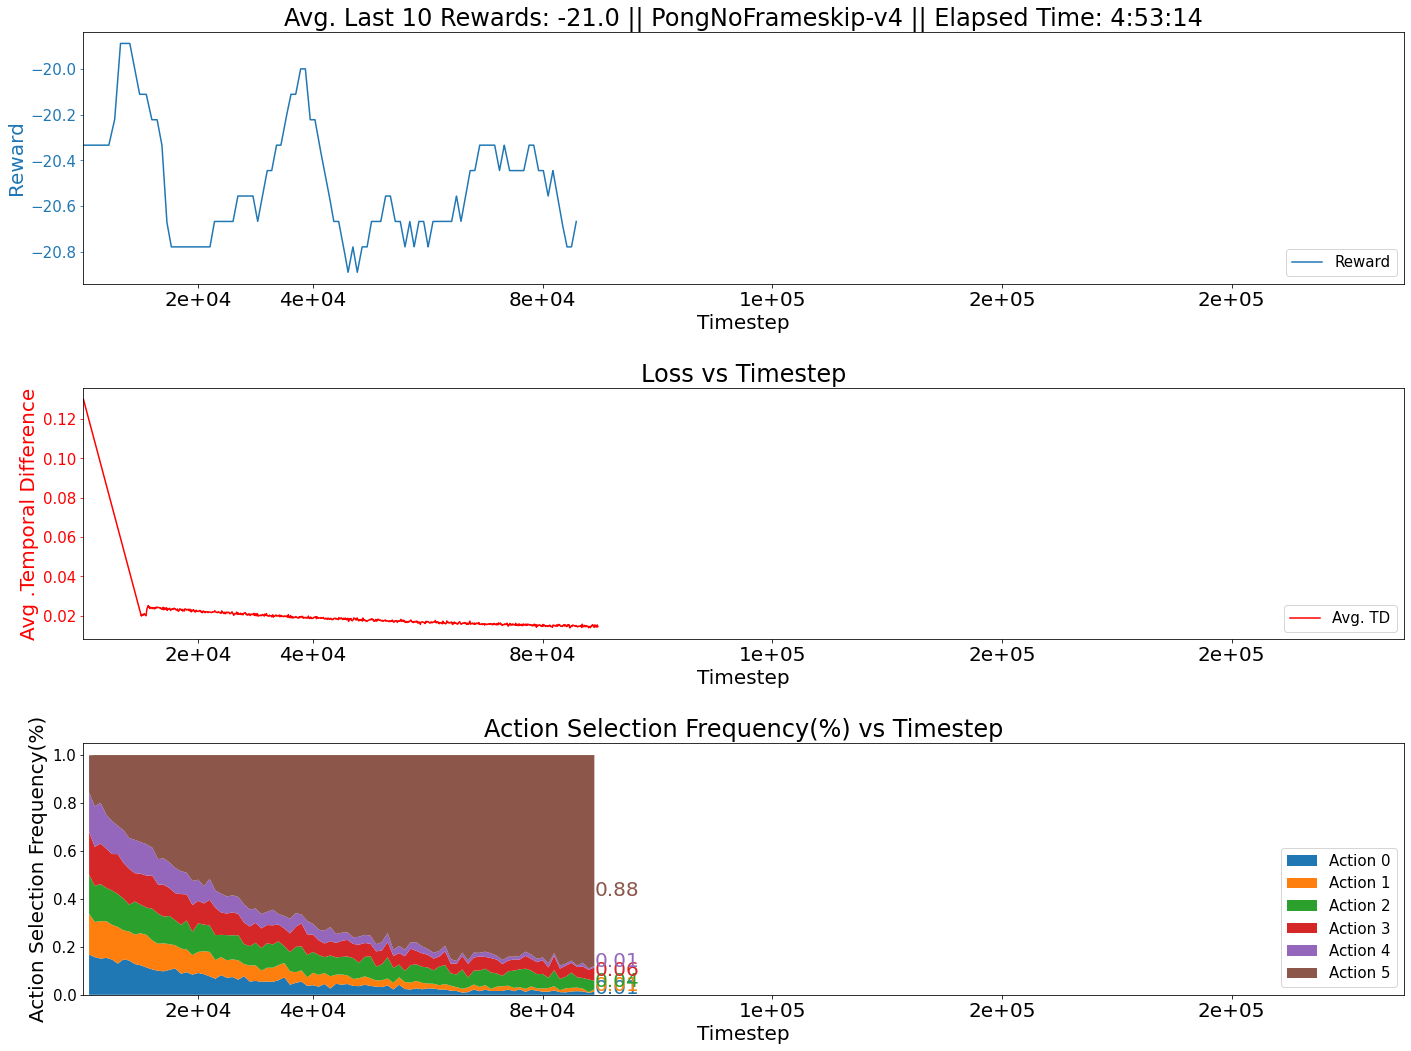

In [ ]:
start = timer()

log_dir = "/tmp/gym/drqn"
try:
    os.makedirs(log_dir)
except OSError:
    files = glob.glob(os.path.join(log_dir, '*.monitor.csv')) \
            + glob.glob(os.path.join(log_dir, '*td.csv')) \
            + glob.glob(os.path.join(log_dir, '*sig_param_mag.csv')) \
            + glob.glob(os.path.join(log_dir, '*action_log.csv'))
    for f in files:
        os.remove(f)
#################################################################################
#                          COMPLETE THE FOLLOWING SECTION                       #
#################################################################################
# do followings line by line:
# * use "make_atari" wrapper and save "PongNoFrameskip-v4" game to env
# * use "bench.Monitor" wrapper to know the episode reward, length, time and other data.
# * use "wrap_deepmind" wrapper to configure environment for DeepMind-style Atari.
# * use *WrapPyTorch*
# * save model
# * implement training loop
#################################################################################
env_id = "PongNoFrameskip-v4"
env = make_atari(env_id)
env=bench.Monitor(env,os.path.join(log_dir,env_id))
env = wrap_deepmind(env, frame_stack=False)
env = WrapPOMDP(env)
model = RecurrentModel(log_dir,env)

episode_reward = 0
observation = env.reset()

for frame_idx in range(1, MAX_FRAMES + 1):
    epsilon = epsilon_by_frame(frame_idx)

    action = model.get_action(observation, epsilon)
    model.save_action(action, frame_idx)

    prev_observation = observation
    observation, reward, done, _ = env.step(action)

    observation = None if done else observation

    model.update(prev_observation, action, reward, observation, frame_idx)
    episode_reward += reward

    if done:
        model.finish_nstep()
        model.reset_hx()
        observation = env.reset()
        model.save_reward(episode_reward)
        episode_reward = 0
        if np.mean(model.rewards[-10:]) > 19:
            break
#################################################################################
#                                   THE END                                     #
################################################################################# 
    if frame_idx % 100 == 0:
        try:
            clear_output(True)
            plot_all_data(log_dir, env_id, 'DRQN', MAX_FRAMES, bin_size=(10, 100, 100, 1), smooth=1,
                          time=timedelta(seconds=int(timer() - start)), ipynb=True)
        except IOError:
            pass

env.close()
plot_all_data(log_dir, env_id, 'DRQN', MAX_FRAMES, bin_size=(10, 100, 100, 1), smooth=1,
              time=timedelta(seconds=int(timer() - start)), ipynb=True)

 ## 2.5. Interpret Results (4 Points)

Explain what you have seen. Is using recurrent memory improve performance? support your answer

<div style="direction:rtl;line-height:300%;text-align:justify;" align="justify"><font face="B nazanin" size=4>
 طبق محاسبات تقریبی زمان اجرای مورد نیاز برای اجرای کامل برنامه ی RDQN بیش از 13 ساعت نیاز داشت و به دلیل محدودیت های کولب امکان اجرای کامل الگوریتم RDQN وجود نداشت.
</font></div>

<div style="direction:rtl;line-height:300%;text-align:justify;" align="justify"><font face="B nazanin" size=4>
    همانطور که از شکل مشخص است الگوریتم DRQN روند بهتری در آموزش دارد و نمودار Smoothتر و به دلیل ویژگی شبکه های بازگشتی که حافظه دارد بسیاری از ویزگی های بازی در هر مرحله ذخیره می شود و در گام های بعدی مورد استفاده قرار می گیرد و این مسئله روند آموزش را بهبود می دهد. این مسئله به این علت است که در روش DQN صرفا یک سری از ویژگی های همان مرحله توسط شبکه استخراج می شود و ویژگی های دیگر که برای مراحل قبل است در مرحله ی بعد دیده نمی شود 
</font></div>